# **Actividad: Clasificación de ataques al corazón con técnicas de balanceo de datos**

## Objetivo
Explorar y aplicar técnicas de **submuestreo, sobremuestreo y SMOTE** en un conjunto de datos de salud para mejorar la clasificación de ataques al corazón.

---

## Contexto del Dataset

https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

Trabajaremos con datos reales de salud que incluyen información sobre factores de riesgo y enfermedades. Nuestra variable objetivo será **`HadHeartAttack`**, que indica si un paciente ha sufrido un ataque al corazón.

🔹 **Clases**:
- **No (0):** La persona **no** ha tenido un ataque al corazón (**93.85%** de los datos).
- **Sí (1):** La persona **sí** ha tenido un ataque al corazón (**6.15%** de los datos).

**El problema**: La variable está **fuertemente desbalanceada**, lo que podría afectar el desempeño del modelo.

### Paso 1: Cargar y explorar los datos
1. Cargar el dataset `heart_2022_no_nans.csv`.
2. Explorar la distribución de clases de la variable `HadHeartAttack`.
3. Visualizar la proporción de pacientes con y sin ataques al corazón mediante un gráfico de barras.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

/tmp/ipykernel_5643/2275115755.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="HadHeartAttack", data=df, palette="coolwarm")


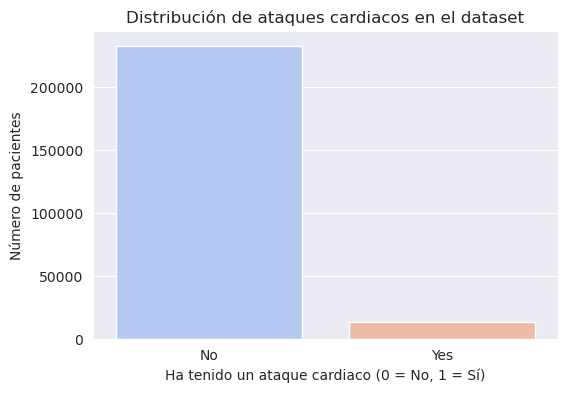

(None,
      State     Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
 0  Alabama  Female     Very good                 4.0               0.0   
 1  Alabama    Male     Very good                 0.0               0.0   
 2  Alabama    Male     Very good                 0.0               0.0   
 3  Alabama  Female          Fair                 5.0               0.0   
 4  Alabama  Female          Good                 3.0              15.0   
 
                                      LastCheckupTime PhysicalActivities  \
 0  Within past year (anytime less than 12 months ...                Yes   
 1  Within past year (anytime less than 12 months ...                Yes   
 2  Within past year (anytime less than 12 months ...                 No   
 3  Within past year (anytime less than 12 months ...                Yes   
 4  Within past year (anytime less than 12 months ...                Yes   
 
    SleepHours            RemovedTeeth HadHeartAttack  ... HeightInMeters  \
 0    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# cargar base
df = pd.read_csv('heart_2022_no_nans.csv')

# Mostrar información general del dataset
df_info =df.info()

# Mostrar las primeras filas del dataset
df_head = df.head()

# Contar la cantidad de clases en la variable objetivo "HadHeartAttack"
class_distribution = df["HadHeartAttack"].value_counts(normalize=True)

# Crear un gráfico de barras para visualizar el desbalance de clases
plt.figure(figsize=(6, 4))
sns.countplot(x="HadHeartAttack", data=df, palette="coolwarm")
plt.title("Distribución de ataques cardiacos en el dataset")
plt.xlabel("Ha tenido un ataque cardiaco (0 = No, 1 = Sí)")
plt.ylabel("Número de pacientes")
plt.show()

# Mostrar resultados
df_info, df_head, class_distribution

In [2]:
df.isna().sum()

State                        0
Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI     


### Paso 2: Aplicar técnicas de balanceo
Usaremos tres técnicas para balancear los datos:

1. **Submuestreo de la clase mayoritaria**: Reduciremos el número de casos de la clase mayoritaria (`No`) para igualar la cantidad de la clase minoritaria (`Sí`).

2. **Sobremuestreo de la clase minoritaria**: Aumentaremos la cantidad de casos de la clase minoritaria (`Sí`) replicando ejemplos existentes.

3. **SMOTE (Synthetic Minority Over-sampling Technique)**: Generaremos **nuevas observaciones sintéticas** de la clase minoritaria en lugar de simplemente replicarlas.

Vamos a crear la variable dummy para `HadHeartAttack` en el dataframe completo

In [3]:
# Transformando la variable HadHeartAttacks a 0 y 1

df['HadHeartAttack'] = df['HadHeartAttack'].apply(lambda x: 1 if x == 'Yes' else 0)

Ahora vamos a convertir todas la variables categóricas a dummies y separamos la variable de interés de los demás datos

Teniendo los conjuntos de datos, vamos a aplicar las técnicas

#### Submuestreo

In [4]:
# insta!pip install ace-tools-open
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import ace_tools_open as tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.9 MB/s eta 0:00:00


In [5]:
# Separar clases
df_majority = df[df['HadHeartAttack'] == 0]
df_minority = df[df['HadHeartAttack'] == 1]


In [6]:
# 1. Submuestreo de la clase mayoritaria
df_majority_downsampled = resample(df_majority,
                                   replace=False,   # Sin reemplazo
                                   n_samples=len(df_minority),  # Igualar tamaño de la minoritaria
                                   random_state=42)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

### Sobremuestreo

In [7]:
# 2. Sobremuestreo de la clase minoritaria
df_minority_upsampled = resample(df_minority,
                                 replace=True,    # Con reemplazo
                                 n_samples=len(df_majority),  # Igualar tamaño de la mayoritaria
                                 random_state=42)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

### SMOTE

In [12]:
# 3. Aplicación de SMOTE

# Separando la variable de respuesta para convertir las demás variables a dummies

y = df['HadHeartAttack']
X = df.drop('HadHeartAttack', axis=1)

# Ahora obteniendo los nombres de las columnas categóricas
categorical_variables = X.select_dtypes(include=['object', 'category']).columns

# obteniendo las variables dummies
X = pd.get_dummies(X, columns=categorical_variables, drop_first=True)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [14]:
X.isna().sum()

,0
PhysicalHealthDays,0
MentalHealthDays,0
SleepHours,1
HeightInMeters,1
WeightInKilograms,1
...,...
"TetanusLast10Tdap_Yes, received tetanus shot but not sure what type",0
"TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap",0
HighRiskLastYear_Yes,0
CovidPos_Tested positive using home test without a health professional,0


In [17]:
# Crear dataframes balanceados
df_smote = pd.concat([pd.DataFrame(X_smote, columns=X.columns), pd.DataFrame(y_smote, columns=['HadHeartAttack'])], axis=1)

# Verificar la distribución de clases después del balanceo
balanced_counts = {
    "Submuestreo": df_downsampled['HadHeartAttack'].value_counts(),
    "Sobremuestreo": df_upsampled['HadHeartAttack'].value_counts(),
    "SMOTE": df_smote['HadHeartAttack'].value_counts()
}

# Mostrar resultados en DataFrame
balance_df = pd.DataFrame(balanced_counts)
tools.display_dataframe_to_user(name="Distribución de Clases Tras Balanceo", dataframe=balance_df)



Distribución de Clases Tras Balanceo


### Paso 3: Entrenar un modelo de clasificación
1. Dividir los datos en **conjunto de entrenamiento (80%)** y **conjunto de prueba (20%)**.
2. Entrenar un **Random Forest Classifier** en los siguientes escenarios:
   - **Sin balanceo**
   - **Con submuestreo**
   - **Con sobremuestreo**
   - **Con SMOTE**
3. Evaluar el rendimiento del modelo con:
   - **Precisión (Accuracy)**
   - **Matriz de confusión**
   - **Curva ROC y AUC**

### Entrenamientos y evaluación

In [63]:
def train_and_evaluate_model(df_to_use, method_name):
    # Separando la variable de respuesta para convertir las demás variables a dummies

    y = df_to_use['HadHeartAttack']
    X = df_to_use.drop('HadHeartAttack', axis=1)

    # Ahora obteniendo los nombres de las columnas categóricas
    categorical_variables = X.select_dtypes(include=['object', 'category']).columns

    # obteniendo las variables dummies
    X = pd.get_dummies(X, columns=categorical_variables, drop_first=True)

    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Entrenar modelo de Random Forest con los mismos parámetros que el modelo original
    clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
    clf.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = clf.predict(X_test)

    # Evaluar métricas de desempeño
    classification_rep = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Mostrar resultados
    print(f"\nResultados para el dataset {method_name}:")
    print(f"Precisión del modelo: {accuracy:.4f}")
    print("Reporte de Clasificación:")
    print(classification_rep)

    # Mostrar matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Sin ataque", "Con ataque"], yticklabels=["Sin ataque", "Con ataque"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {method_name}")
    plt.show()

    # Curva ROC y AUC
    y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1)
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title(f"Curva ROC {method_name}")
    plt.legend(loc="lower right")
    plt.show()



Resultados para el dataset Sin balanceo:
Precisión del modelo: 0.9458
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     46518
           1       0.74      0.01      0.02      2687

    accuracy                           0.95     49205
   macro avg       0.84      0.51      0.50     49205
weighted avg       0.93      0.95      0.92     49205



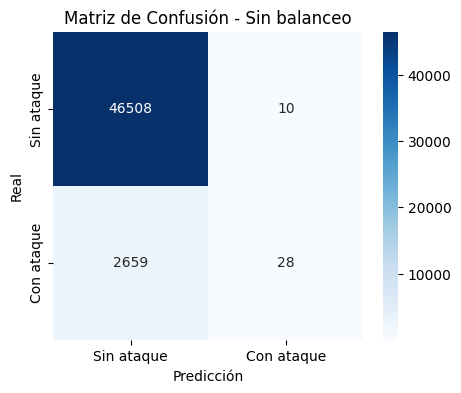

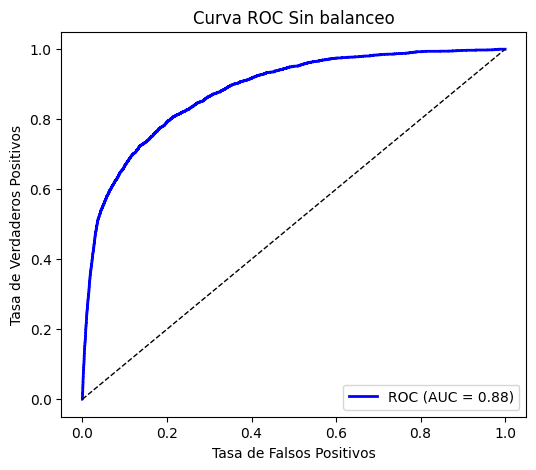

In [64]:
train_and_evaluate_model(df, "Sin balanceo")


Resultados para el dataset Submuestreo:
Precisión del modelo: 0.7996
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      2687
           1       0.82      0.77      0.79      2687

    accuracy                           0.80      5374
   macro avg       0.80      0.80      0.80      5374
weighted avg       0.80      0.80      0.80      5374



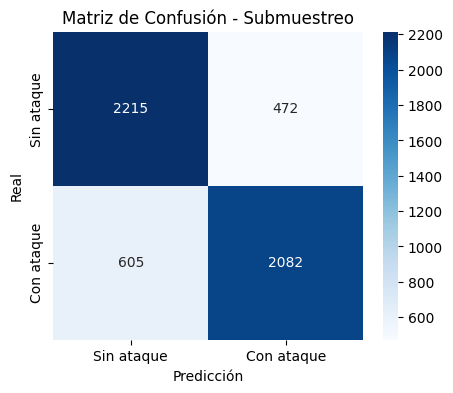

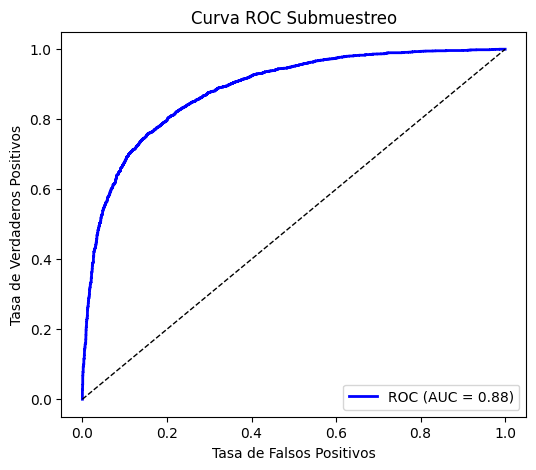

In [65]:
train_and_evaluate_model(df_downsampled, "Submuestreo")


Resultados para el dataset Sobremuestreo:
Precisión del modelo: 0.8153
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     46518
           1       0.81      0.82      0.82     46517

    accuracy                           0.82     93035
   macro avg       0.82      0.82      0.82     93035
weighted avg       0.82      0.82      0.82     93035



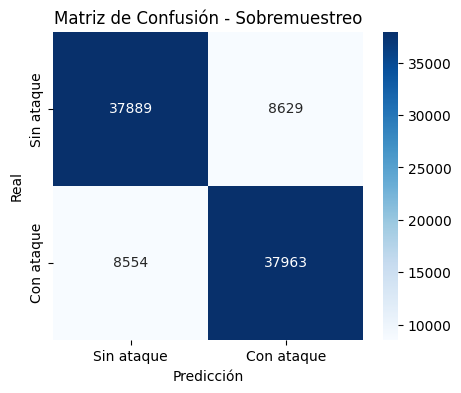

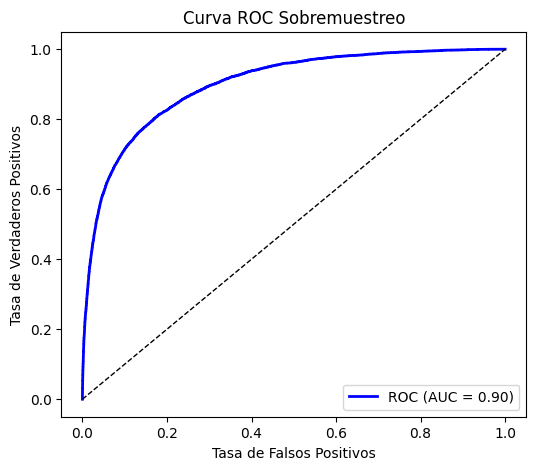

In [66]:
train_and_evaluate_model(df_upsampled, "Sobremuestreo")


Resultados para el dataset SMOTE:
Precisión del modelo: 0.9136
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     46518
           1       0.92      0.91      0.91     46517

    accuracy                           0.91     93035
   macro avg       0.91      0.91      0.91     93035
weighted avg       0.91      0.91      0.91     93035



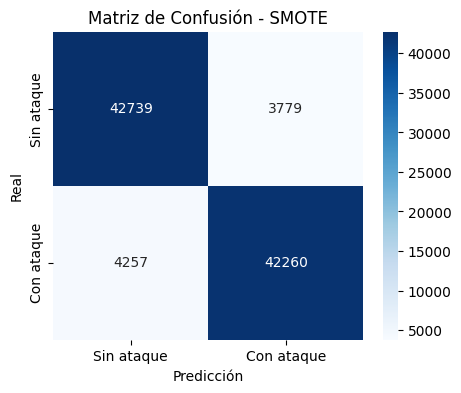

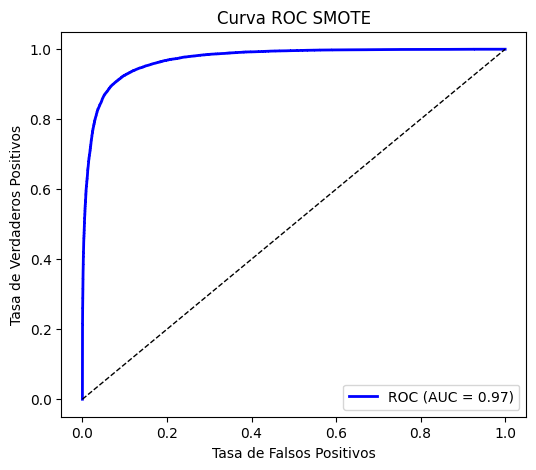

In [67]:
train_and_evaluate_model(df_smote, "SMOTE")

### Paso 4: Analizar y comparar resultados
**Preguntas de análisis**:
1. ¿Cómo afecta el desbalance de clases a la clasificación sin técnicas de balanceo?

    **El desbalance de las clases hace que el modelo esté sesgado, y sólo logre identificar las características de la clase con más balance**
2. ¿Cuál de las tres técnicas de balanceo mejora más la predicción?

    **La técnica SMOT mejora la clasficación**
3. ¿Qué ventajas y desventajas tiene cada método?

Sobremuestreo (Oversampling)

Ventajas:
* No se pierde información: Al replicar las instancias de la clase minoritaria, se conserva toda la información original del conjunto de datos.
* Mejora el rendimiento del modelo: Al aumentar la representación de la clase minoritaria, el modelo puede aprender mejor sus características y patrones, lo que puede mejorar su capacidad para predecir correctamente las instancias de esta clase.

Desventajas:
* Riesgo de sobreajuste: Al duplicar instancias existentes, se aumenta la probabilidad de que el modelo se sobreajuste a los datos de entrenamiento, lo que puede reducir su capacidad de generalización a nuevos datos.
* No aporta nueva información: El sobremuestreo simplemente replica la información existente, sin introducir nueva información al conjunto de datos.

Submuestreo (Undersampling)

Ventajas:

*Reduce el tiempo de entrenamiento: Al reducir el tamaño del conjunto de datos, el tiempo de entrenamiento del modelo se reduce.
* Puede mejorar el rendimiento del modelo: En algunos casos, el submuestreo puede eliminar instancias ruidosas o redundantes de la clase mayoritaria, lo que puede mejorar la capacidad del modelo para aprender las características relevantes de la clase minoritaria.

Desventajas:

* Pérdida de información: Al eliminar instancias de la clase mayoritaria, se puede perder información valiosa que podría ser útil para el modelo.
* Puede reducir el rendimiento del modelo: Si se eliminan demasiadas instancias de la clase mayoritaria, el modelo puede no tener suficientes datos para aprender sus características correctamente, lo que puede reducir su rendimiento general.


SMOTE (Synthetic Minority Over-sampling Technique)

Ventajas:

* Genera nuevas instancias: SMOTE genera nuevas instancias sintéticas de la clase minoritaria, lo que puede mejorar la capacidad del modelo para aprender sus características y patrones.
* Reduce el riesgo de sobreajuste: Al generar nuevas instancias, SMOTE reduce la probabilidad de que el modelo se sobreajuste a los datos de entrenamiento.

Desventajas:

* Puede introducir ruido: En algunos casos, SMOTE puede generar instancias sintéticas que son ruidosas o que no representan correctamente las características de la clase minoritaria.
* Puede ser computacionalmente costoso: SMOTE puede ser más costoso computacionalmente que otras técnicas de balanceo de clases, especialmente para conjuntos de datos grandes.


4. ¿Qué técnica recomendarías para un problema de salud pública como este?

Al ser un problema de salud, las causas que lo generan podrían no variar, el historial clinico de una persona indica que tan probable puede que tenga un ataque cardiaco, y otra persona con los mismos factores causales puede desarrollar un ataque cardiaco. Por lo que sugeriria la técnica de submuestreo. Eliminar los datos reduntantes por la explicación anterior